# Imports

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import keras
from scripts.ksplot import make_ks_plot
import pickle

# Latex settings block

In [25]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 16,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

# Load training and testing arrays along with their labels and variable and label names
# Thsse files are created by the the explore.ipynb and preprocess_testing.ipynb notebooks

In [5]:
with np.load('root_files/train_validate_49variables.npz') as f:
    X_train = f['X_train']
    y_train = f['y_train']
    features = f['variables'].tolist()
    labels = f['labels'].tolist()
    
with np.load('root_files/test_49variables.npz') as f:
    X_test = f['X_test']
    y_test = f['y_test']
    features = f['variables'].tolist()
    labels = f['labels'].tolist()

# Define which features out of the 49 to use

In [6]:
to_use = [
         # number of tracks and number of SVs always used
          'fj_jetNTracks',
          'fj_nSV',
         # adding full jet kinematics
          'fj_eta',
          'fj_mass',
          'fj_phi',
          'fj_pt',
         # adding kinematic variables defined for the two soft drop subjets
          'fj_ptDR',
          'fj_relptdiff',
          'fj_sdn2',
          'fj_sdsj1_eta',
          'fj_sdsj1_mass',
          'fj_sdsj1_phi',
          'fj_sdsj1_pt',
          'fj_sdsj1_ptD',
          'fj_sdsj2_eta',
          'fj_sdsj2_mass',
          'fj_sdsj2_phi',
          'fj_sdsj2_pt',
          'fj_sdsj2_ptD',
          'fj_z_ratio',
         # adding N-subjettiness variables
          'fj_tau1',
          'fj_tau2',
          'fj_tau3',
          'fj_tau21',
          'fj_tau32',
          # adding variables related to N-subjettines axes
          'fj_tau0_trackEtaRel_0',
          'fj_tau0_trackEtaRel_1',
          'fj_tau0_trackEtaRel_2',
          'fj_tau1_trackEtaRel_0',
          'fj_tau1_trackEtaRel_1',
          'fj_tau1_trackEtaRel_2',
          'fj_tau_vertexMass_0',
          'fj_tau_vertexMass_1',
          'fj_tau_vertexEnergyRatio_0',
          'fj_tau_vertexEnergyRatio_1',
          'fj_tau_flightDistance2dSig_0',
          'fj_tau_flightDistance2dSig_1',
          'fj_tau_vertexDeltaR_0',
         # adding impact parameter significance variables
          'fj_trackSipdSig_0',
          'fj_trackSipdSig_1',
          'fj_trackSipdSig_2',
          'fj_trackSipdSig_3',
          'fj_trackSipdSig_0_0',
          'fj_trackSipdSig_0_1',
          'fj_trackSipdSig_1_0',
          'fj_trackSipdSig_1_1',
          'fj_trackSip2dSigAboveCharm_0',
          'fj_trackSip2dSigAboveBottom_0',
          'fj_trackSip2dSigAboveBottom_1'
         ]

num_of_variables = len(to_use)
indices = sorted([features.index(i) for i in to_use])
X_train_final = X_train[:,indices]
X_test_final = X_test[:,indices]

print(X_train_final.shape)
print(X_test_final.shape)

(3022214, 49)
(455742, 49)


# Load the best weights of the keras model

In [28]:
model = keras.models.load_model(f"model_checkpoints/MLP_{num_of_variables}variables.h5")

# Print the loss and accuracy of the model on the train and test data sets
# Run model inference on train and test data sets

In [29]:
evaluation_train = model.evaluate(X_train_final,y_train, batch_size=2**16)
evaluation_test = model.evaluate(X_test_final,y_test, batch_size=2**16)
accuracy = evaluation_test[1]
print(evaluation_train)
print(evaluation_test)

predict_array_train = model.predict(X_train_final, batch_size=2**16)
predict_array_test = model.predict(X_test_final, batch_size=2**16)

7/7 [==============================] - 0s 6ms/step - loss: 0.1703 - accuracy: 0.9321
[0.1688067466020584, 0.93265700340271]
[0.1702950894832611, 0.9320997595787048]
7/7 [==============================] - 0s 5ms/step


# Create ROC curve

In [30]:
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,0])
np.savez(f'plots/ROC_MLP_{num_of_variables}variables_test', fpr = fpr, tpr = tpr)

# Plot ROC curve

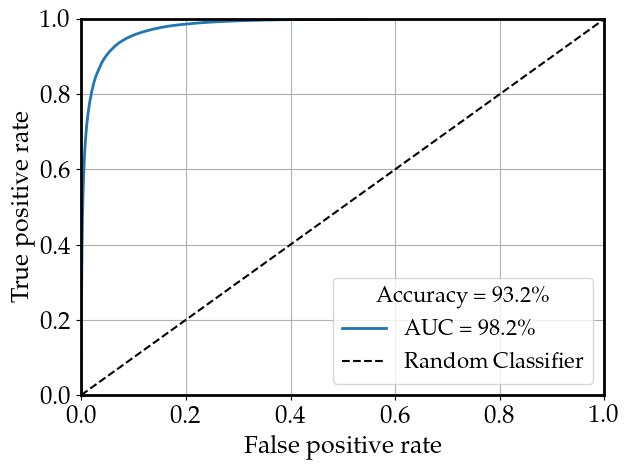

In [31]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right', title=f'Accuracy = {accuracy*100:.1f}\%')
plt.tight_layout()
plt.savefig(f'plots/ROC_MLP_{num_of_variables}variables_test.pdf')
plt.show()

# Create KS histogram of classifier output to check for overtraining

In [32]:
fig = make_ks_plot(y_train[:,0], predict_array_train[:,0],
                   y_test[:,0], predict_array_test[:,0])
fig.savefig(f'plots/KS_MLP_{num_of_variables}variables_test.pdf')

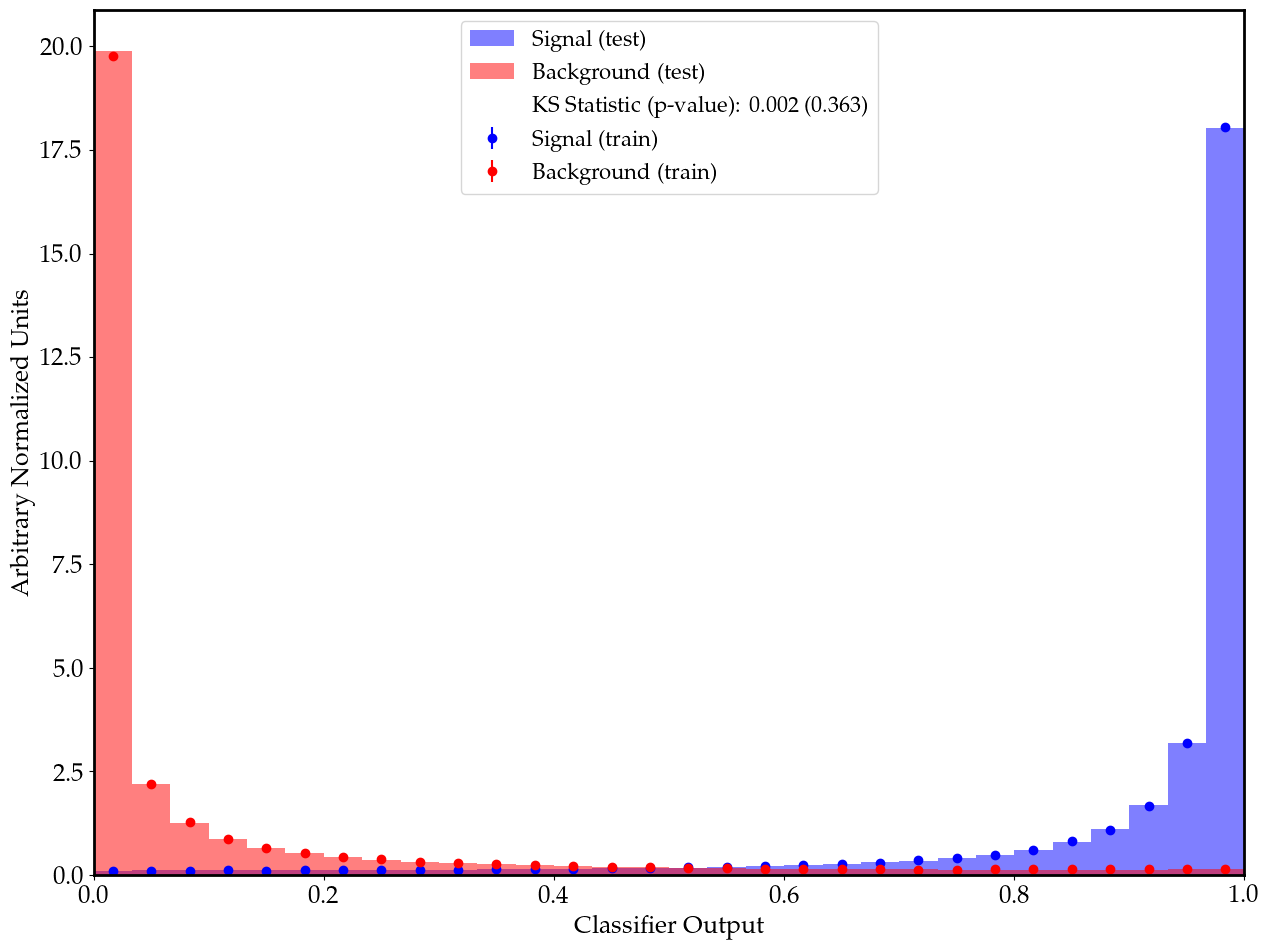

In [33]:
fig

In [3]:
bdt = XGBClassifier()

# Load the best state of the BDT classifier

In [7]:
bdt.load_model(f"model_checkpoints/BDT_{num_of_variables}variables.json")

# Print the accuracies of the BDT on the training and testing data sets

In [8]:
print(bdt.score(X_train_final, y_train))
accuracy = bdt.score(X_test_final, y_test)
print(accuracy)

0.9456438227074588
0.9427834169332648


# Run BDT inference on train and test data sets and create ROC curve

In [37]:
predict_array_train = bdt.predict_proba(X_train_final)
predict_array_test = bdt.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,0])
np.savez(f'plots/ROC_BDT_{num_of_variables}variables_test', fpr = fpr, tpr = tpr)

# Plot ROC curve

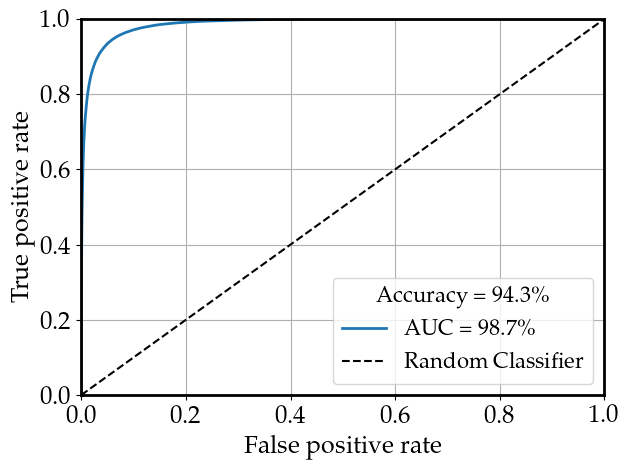

In [38]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right', title=f'Accuracy = {accuracy*100:.1f}\%')
plt.tight_layout()
plt.savefig(f'plots/ROC_BDT_{num_of_variables}variables_test.pdf')
plt.show()

# Create KS histogram of classifier output to check for overtraining

In [39]:
fig = make_ks_plot(y_train[:,0], predict_array_train[:,0],
                   y_test[:,0], predict_array_test[:,0])
fig.savefig(f'plots/KS_BDT_{num_of_variables}variables_test.pdf')

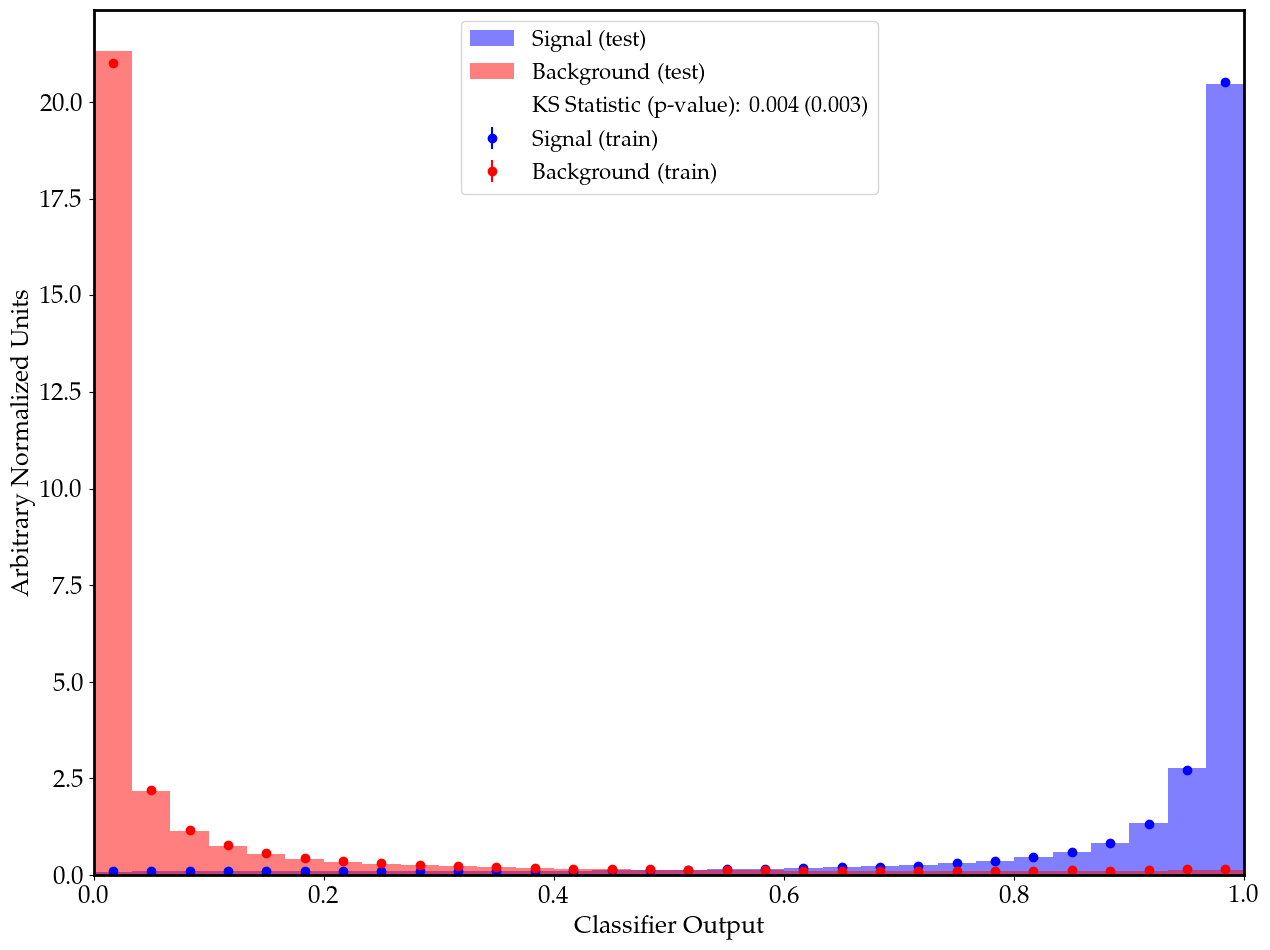

In [40]:
fig

# Load the best state of the LDA classifier

In [41]:
with open(f"model_checkpoints/LDA_{num_of_variables}variables.pkl", 'rb') as f:
    fisher = pickle.load(f)

# Print the accuracies of the LDA classifier on the training and testing data sets

In [42]:
print(fisher.score(X_train_final, y_train[:,0]))
accuracy = fisher.score(X_test_final, y_test[:,0])
print(accuracy)

0.8584683281858928
0.8581960846268283


# Run LDA classifier inference on train and test data sets and create ROC curve

In [43]:
predict_array_train = fisher.predict_proba(X_train_final)
predict_array_test = fisher.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,1])
np.savez(f'plots/ROC_LDA_{num_of_variables}variables_test', fpr = fpr, tpr = tpr)

# Plot ROC curve

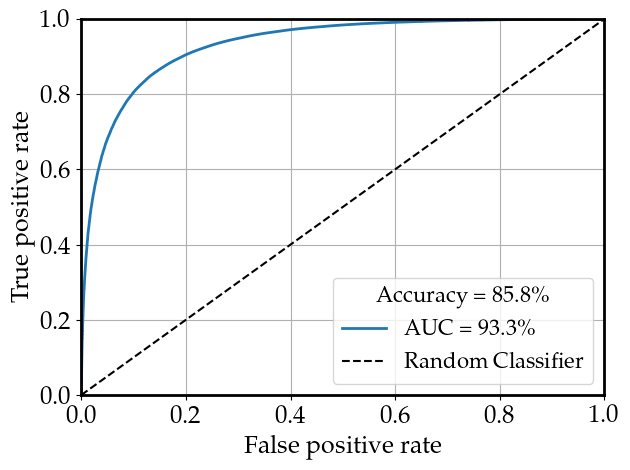

In [44]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right', title=f'Accuracy = {accuracy*100:.1f}\%')
plt.tight_layout()
plt.savefig(f'plots/ROC_LDA_{num_of_variables}variables_test.pdf')
plt.show()

# Create KS histogram of classifier output to check for overtraining

In [45]:
fig = make_ks_plot(y_train[:,0], predict_array_train[:,1],
                   y_test[:,0], predict_array_test[:,1])
fig.savefig(f'plots/KS_LDA_{num_of_variables}variables_test.pdf')

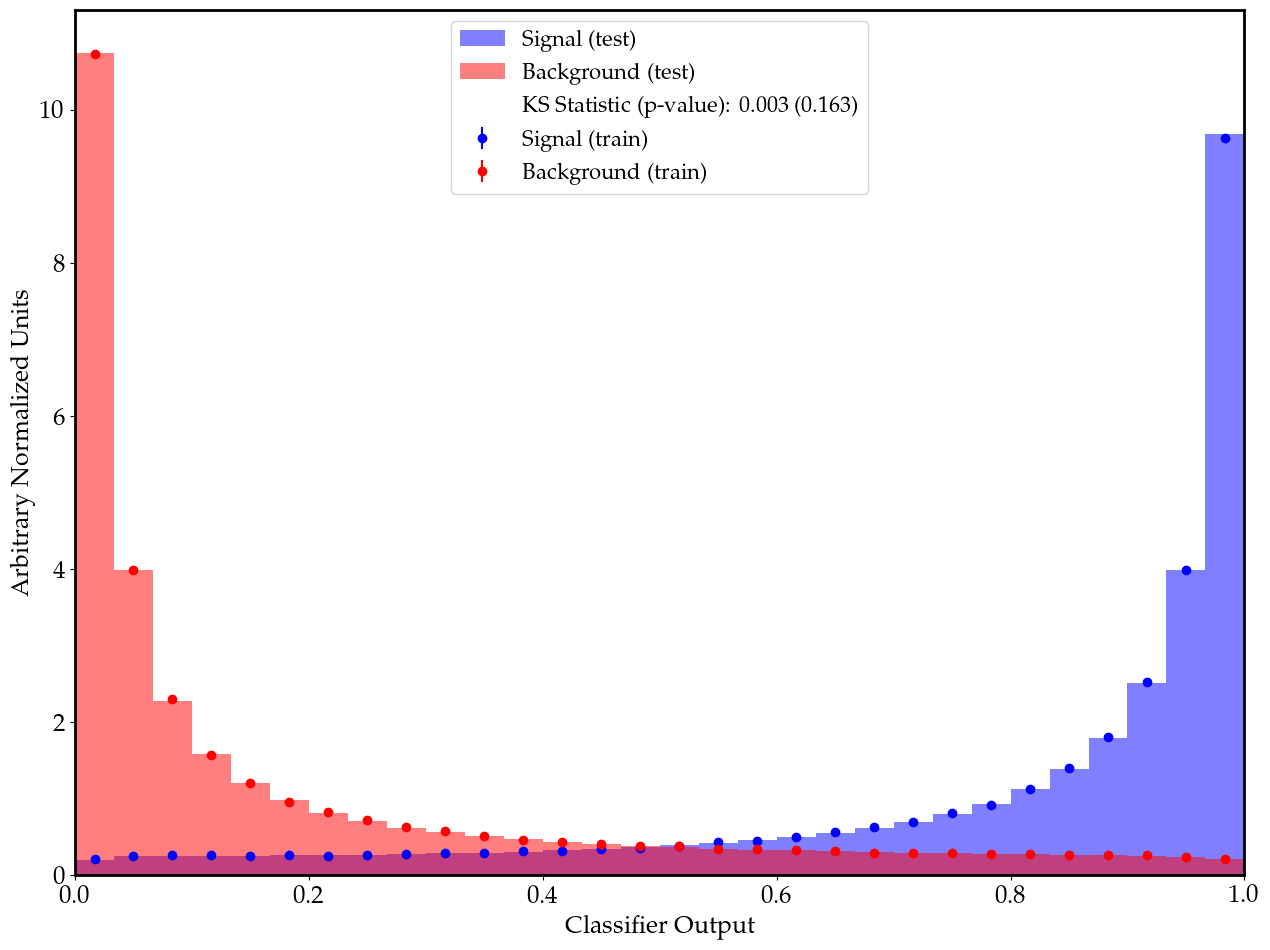

In [46]:
fig